### Домашнее задание (часть 2)

1. Придумать новые признаки (у нас их всего 5 было) - сделать дополнительный feature engineering
2. Для подходов с одной моделью поварьировать параметры CatBoostClassifier либо даже попробовать другой алгоритм (опционально уже). 
3. Для пункта 2 (подходов на основе одной модели) вывести значимость признаков, основываясь на model.estimator.feature_importances_ и model.estimator.feature_names_. 
4. Дополнить models_results дополнительными метриками (roc auc, logloss, f1). В конце вывести сводную таблицу всех показателей для всех подходов (как на основе

In [1]:
%matplotlib inline

import pandas as pd
#import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


# Чтение данных
df_clients = pd.read_csv('./data/clients.csv', index_col='client_id', parse_dates=[0,1,2])
df_train = pd.read_csv('./data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('./data/uplift_test.csv', index_col='client_id')

# Извлечение признаков
df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']

#df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, 
                                                test_size=0.4, 
                                                random_state=12)

In [2]:
df_clients.head()

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaT,68,F
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


In [3]:
df_train.head()

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1
0001f552b0,1,1
00020e7b18,1,1


In [4]:
df_test.head()

""
client_id
000048b7a6
000073194a
00007c7133
00007f9014
0000a90cf7


In [5]:
df_features.head()

,first_issue_date,first_redeem_date,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,1501947648,1.515094e+09,13146559.0
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1491832463,1.492951e+09,1118613.0
000048b7a6,2018-12-15 13:33:11,NaT,68,F,1544880791,NaN,NaN
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F,1495544174,1.511522e+09,15978107.0
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U,1495469828,1.546277e+09,50806825.0


In [6]:
def extract_date_feauters(data):
    data['issue_year'] = data['first_issue_date'].dt.year#apply(lambda x: x.year, 1)
    data['issue_month'] = data['first_issue_date'].dt.month
    data['issue_dayofmonth'] = data['first_issue_date'].dt.day
    data['issue_quarter'] = data['first_issue_date'].dt.quarter
    data['issue_dayofyear'] = data['first_issue_date'].dt.dayofyear
    data['issue_weekofyear'] = data['first_issue_date'].dt.weekofyear
    data['issue_dayofweek'] = data['first_issue_date'].dt.dayofweek
    data['issue_hour'] = data['first_issue_date'].dt.hour
    
    data['redeem_year'] = data['first_redeem_date'].dt.year#apply(lambda x: x.year, 1)
    data['redeem_month'] = data['first_redeem_date'].dt.month
    data['redeem_dayofmonth'] = data['first_redeem_date'].dt.day
    data['redeem_quarter'] = data['first_redeem_date'].dt.quarter
    data['redeem_dayofyear'] = data['first_redeem_date'].dt.dayofyear
    data['redeem_weekofyear'] = data['first_redeem_date'].dt.weekofyear
    data['redeem_dayofweek'] = data['first_redeem_date'].dt.dayofweek
    data['redeem_hour'] = data['first_redeem_date'].dt.hour
    return data

In [7]:
#новые фичи а основе даты
df_features = extract_date_feauters(df_features)

In [8]:
df_features.shape

(400162, 23)

In [9]:
df_features.describe()

,age,first_issue_time,first_redeem_time,issue_redeem_delay,issue_year,issue_month,issue_dayofmonth,issue_quarter,issue_dayofyear,issue_weekofyear,issue_dayofweek,issue_hour,redeem_year,redeem_month,redeem_dayofmonth,redeem_quarter,redeem_dayofyear,redeem_weekofyear,redeem_dayofweek,redeem_hour
count,400162.000000,4.001620e+05,3.646930e+05,3.646930e+05,400162.000000,400162.000000,400162.000000,400162.000000,400162.000000,400162.000000,400162.000000,400162.000000,364693.000000,364693.000000,364693.000000,364693.000000,364693.000000,364693.000000,364693.000000,364693.000000
mean,46.488112,1.515519e+09,1.530007e+09,1.558871e+07,2017.474310,7.106150,16.083099,2.696860,200.960164,29.004068,2.946632,14.951260,2017.971307,6.648825,16.167939,2.522102,187.227953,26.988637,3.124000,15.231702
std,43.871218,1.759150e+07,1.888414e+07,1.351122e+07,0.617489,3.204315,8.887517,1.029755,97.935459,13.957895,1.941117,3.620222,0.731983,3.695696,8.927526,1.186948,113.640218,16.170240,1.933935,3.498122
min,-7491.000000,1.491330e+09,1.491904e+09,-3.701689e+06,2017.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,34.000000,1.500667e+09,1.514128e+09,5.368447e+06,2017.000000,5.000000,8.000000,2.000000,137.000000,20.000000,1.000000,12.000000,2017.000000,3.000000,8.000000,1.000000,81.000000,12.000000,1.000000,13.000000
50%,45.000000,1.510845e+09,1.528319e+09,1.148628e+07,2017.000000,7.000000,16.000000,3.000000,203.000000,29.000000,3.000000,15.000000,2018.000000,7.000000,16.000000,3.000000,188.000000,27.000000,3.000000,15.000000
75%,59.000000,1.529518e+09,1.546628e+09,2.185546e+07,2018.000000,10.000000,24.000000,4.000000,280.000000,40.000000,5.000000,18.000000,2019.000000,10.000000,24.000000,4.000000,290.000000,42.000000,5.000000,18.000000
max,1901.000000,1.552687e+09,1.574212e+09,8.198520e+07,2019.000000,12.000000,31.000000,4.000000,365.000000,52.000000,6.000000,23.000000,2019.000000,12.000000,31.000000,4.000000,365.000000,52.000000,6.000000,23.000000


In [10]:
import os
os.system("pip install holidays")
import holidays

RF=holidays.RU(years =[2017,2018,2019])
RF

{datetime.date(2017, 1, 1): 'Новый год',
 datetime.date(2017, 1, 2): 'Новый год',
 datetime.date(2017, 1, 3): 'Новый год',
 datetime.date(2017, 1, 4): 'Новый год',
 datetime.date(2017, 1, 5): 'Новый год',
 datetime.date(2017, 1, 6): 'Новый год',
 datetime.date(2017, 1, 7): 'Православное Рождество',
 datetime.date(2017, 1, 8): 'Новый год',
 datetime.date(2017, 2, 23): 'День защитника отечества',
 datetime.date(2017, 3, 8): 'День женщин',
 datetime.date(2017, 5, 1): 'Праздник Весны и Труда',
 datetime.date(2017, 5, 9): 'День Победы',
 datetime.date(2017, 6, 12): 'День России',
 datetime.date(2017, 11, 4): 'День народного единства',
 datetime.date(2018, 1, 1): 'Новый год',
 datetime.date(2018, 1, 2): 'Новый год',
 datetime.date(2018, 1, 3): 'Новый год',
 datetime.date(2018, 1, 4): 'Новый год',
 datetime.date(2018, 1, 5): 'Новый год',
 datetime.date(2018, 1, 6): 'Новый год',
 datetime.date(2018, 1, 7): 'Православное Рождество',
 datetime.date(2018, 1, 8): 'Новый год',
 datetime.date(2018, 

In [11]:
ru_holidays = []
for date in RF.items():
    ru_holidays.append(str(date[0]))

In [12]:
#новые фичи - дата является праздничным днем
df_features['issue_is_holiday'] = [1 if str(val).split()[0] in ru_holidays else 0 for val in df_features['first_issue_date']]
df_features['redeem_is_holiday'] = [1 if str(val).split()[0] in ru_holidays else 0 for val in df_features['first_redeem_date']]

In [13]:
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

In [14]:
df_features.head()

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay,issue_year,issue_month,issue_dayofmonth,issue_quarter,issue_dayofyear,...,redeem_year,redeem_month,redeem_dayofmonth,redeem_quarter,redeem_dayofyear,redeem_weekofyear,redeem_dayofweek,redeem_hour,issue_is_holiday,redeem_is_holiday
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,45,U,1501947648,1.515094e+09,13146559.0,2017,8,5,3,217,...,2018.0,1.0,4.0,1.0,4.0,1.0,3.0,19.0,0,1
000036f903,72,F,1491832463,1.492951e+09,1118613.0,2017,4,10,2,100,...,2017.0,4.0,23.0,2.0,113.0,16.0,6.0,12.0,0,0
000048b7a6,68,F,1544880791,NaN,NaN,2018,12,15,4,349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
000073194a,60,F,1495544174,1.511522e+09,15978107.0,2017,5,23,2,143,...,2017.0,11.0,24.0,4.0,328.0,47.0,4.0,11.0,0,0
00007c7133,67,U,1495469828,1.546277e+09,50806825.0,2017,5,22,2,142,...,2018.0,12.0,31.0,4.0,365.0,1.0,0.0,17.0,0,0


In [15]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': [],
    'uplift_auc_score': []
}

### 1.1 Одна модель с признаком коммуникации

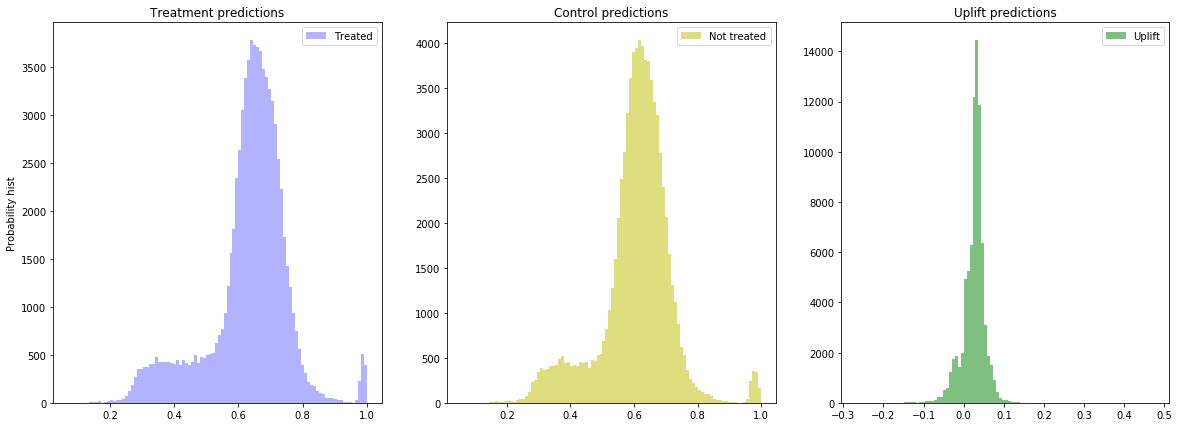

In [16]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.metrics import uplift_auc_score
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=50, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
sm_score2 = uplift_auc_score(y_true=y_val, uplift=uplift_sm, treatment=treat_val)

models_results['approach'].append('SoloModel_iterations=50')
models_results['uplift@30%'].append(sm_score)
models_results['uplift_auc_score'].append(sm_score2)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [17]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,redeem_dayofyear,44.215164
1,first_redeem_time,16.065865
2,redeem_year,8.547244
3,redeem_dayofmonth,5.386609
4,age,4.785695
5,first_issue_time,2.596608
6,issue_redeem_delay,2.470060
7,redeem_hour,2.423032
8,issue_hour,2.270925
9,issue_dayofyear,1.812549


In [18]:
#посмотрим на models_results
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%,uplift_auc_score
0,SoloModel_iterations=50,0.034851,0.003266


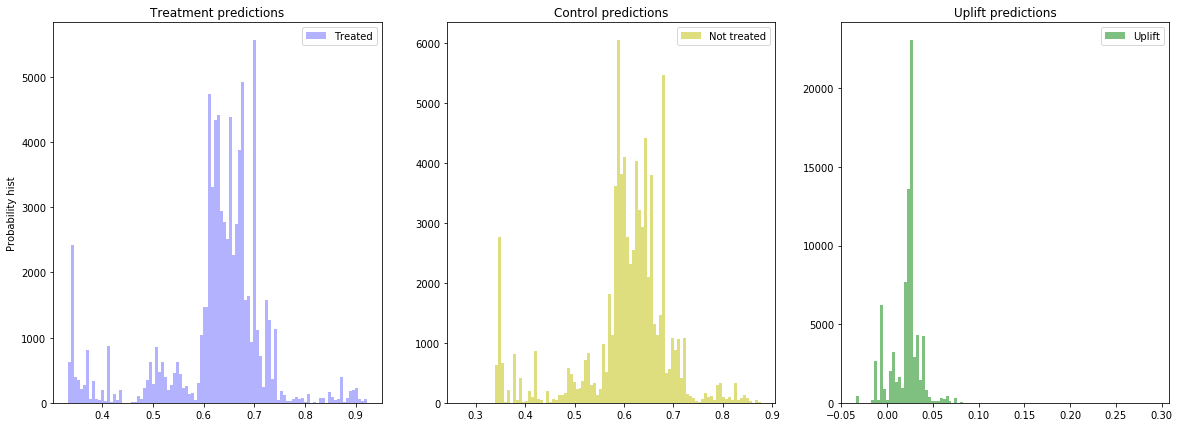

In [19]:
sm = SoloModel(CatBoostClassifier(iterations=5, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
sm_score2 = uplift_auc_score(y_true=y_val, uplift=uplift_sm, treatment=treat_val)

models_results['approach'].append('SoloModel_iterations=5')
models_results['uplift@30%'].append(sm_score)
models_results['uplift_auc_score'].append(sm_score2)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [20]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,redeem_year,30.475852
1,first_redeem_time,28.169587
2,redeem_dayofmonth,13.783119
3,redeem_dayofyear,12.509577
4,age,4.796994
5,treatment,2.533435
6,issue_redeem_delay,1.688361
7,first_issue_time,1.371614
8,redeem_quarter,1.144654
9,redeem_weekofyear,1.034286


In [21]:
#посмотрим на models_results
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)
#models_results

,approach,uplift@30%,uplift_auc_score
1,SoloModel_iterations=5,0.050510,0.017694
0,SoloModel_iterations=50,0.034851,0.003266


### 1.2 Трансформация классов

In [22]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=50, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)
ct_score2 = uplift_auc_score(y_true=y_val, uplift=uplift_ct, treatment=treat_val)

models_results['approach'].append('ClassTransformation_iterations=50')
models_results['uplift@30%'].append(ct_score)
models_results['uplift_auc_score'].append(ct_score2)

C:\Users\sych_\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


In [23]:
#посмотрим на models_results
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%,uplift_auc_score
2,ClassTransformation_iterations=50,0.051784,0.015591
1,SoloModel_iterations=5,0.050510,0.017694
0,SoloModel_iterations=50,0.034851,0.003266


In [24]:
ct = ClassTransformation(CatBoostClassifier(iterations=5, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)
ct_score2 = uplift_auc_score(y_true=y_val, uplift=uplift_ct, treatment=treat_val)

models_results['approach'].append('ClassTransformation_iterations=5')
models_results['uplift@30%'].append(ct_score)
models_results['uplift_auc_score'].append(sm_score2)

C:\Users\sych_\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


In [25]:
#посмотрим на models_results
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%,uplift_auc_score
3,ClassTransformation_iterations=5,0.056014,0.017694
2,ClassTransformation_iterations=50,0.051784,0.015591
1,SoloModel_iterations=5,0.050510,0.017694
0,SoloModel_iterations=50,0.034851,0.003266


## метрики logloss и f1 для алгоритма uplift в докуметации не нашла